In [12]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv('./../Naive_Bayes/tweets/allLabeledTweets.csv')
df.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,retweetedId,retweetCount,label,message_lowercase,clean_message,clean_message_no_punct,clean_message_no_stopwords_from_list,clean_message_no_punct_no_stopwords_from_list,clean_message_no_punct_no_freq_stopwords,clean_message_no_freq_stopwords
0,"Rodas sajūta, ka arī @airBaltic ir kaut kāds @...",0,1213615462581440500,2020-01-05T00:17:28+00:00,lv,NaN,NaN,NaN,62004316,Edgars Eglītis,...,NaN,0,2,"rodas sajūta, ka arī @airbaltic ir kaut kāds @...","rodas sajūta, ka arī MENTION ir kaut kāds MENT...",rodas sajūta ka arī MENTION ir kaut kāds MENT...,"rodas sajūta , MENTION kāds MENTION kaktu kant...",rodas sajūta MENTION kāds MENTION kaktu kantor...,rodas sajūta MENTION kaut MENTION kaktu kantor...,"rodas sajūta , MENTION kaut MENTION kaktu kant..."
1,"Amsterdama, @airBaltic smukulītes 👍🏻 https://...",0,1213740889476128800,2020-01-05T08:35:52+00:00,lv,NaN,NaN,NaN,213752948,Dairis Kuciks,...,NaN,0,1,"amsterdama, @airbaltic smukulītes 👍🏻 https://...","amsterdama, MENTION smukulītes 👍🏻 URL",amsterdama MENTION smukulītes 👍🏻 URL,"amsterdama , MENTION smukulītes 👍🏻 URL",amsterdama MENTION smukulītes 👍🏻 URL,amsterdama MENTION smukulītes 👍🏻 URL,"amsterdama , MENTION smukulītes 👍🏻 URL"
2,Kārtējo reizi... \r\n@airBaltic vakar raudošai...,0,1214174186069012500,2020-01-06T13:17:38+00:00,lv,NaN,NaN,NaN,1107743410646069200,Selma,...,NaN,73,2,kārtējo reizi... \r\n@airbaltic vakar raudošai...,kārtējo reizi... MENTION vakar raudošai sievie...,kārtējo reizi MENTION vakar raudošai sievie...,kārtējo reizi ... MENTION vakar raudošai sievi...,kārtējo reizi MENTION vakar raudošai sievietei...,kārtējo reizi MENTION vakar raudošai sievietei...,kārtējo reizi ... MENTION vakar raudošai sievi...
3,80.05% airBaltic akciju pieder Latvijas valsti...,0,1214176732456075300,2020-01-06T13:27:45+00:00,lv,NaN,NaN,NaN,1107743410646069200,Selma,...,NaN,2,2,80.05% airbaltic akciju pieder latvijas valsti...,NMBR % airbaltic akciju pieder latvijas valsti...,NMBR airbaltic akciju pieder latvijas valsti...,NMBR % airbaltic akciju pieder latvijas valsti...,NMBR airbaltic akciju pieder latvijas valstij ...,NMBR airbaltic akciju pieder latvijas valstij ...,NMBR % airbaltic akciju pieder latvijas valsti...
4,Laba ideja lidojumiem ar @airBaltic https://t....,0,1214197047382941700,2020-01-06T14:48:29+00:00,lv,NaN,NaN,NaN,110783755,Inga Gorbunova,...,NaN,4,0,laba ideja lidojumiem ar @airbaltic https://t....,laba ideja lidojumiem ar MENTION URL,laba ideja lidojumiem ar MENTION URL,laba ideja lidojumiem MENTION URL,laba ideja lidojumiem MENTION URL,laba ideja lidojumiem MENTION URL,laba ideja lidojumiem MENTION URL


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

message   id  tweetId  createdAt  language  \
label data_type                                               
0     train          205  205      205        205       205   
      val             37   37       37         37        37   
1     train           71   71       71         71        71   
      val             13   13       13         13        13   
2     train          103  103      103        103       103   
      val             18   18       18         18        18   

                 inReplyToStatusId  inReplyToUserId  inReplyToScreenName  \
label data_type                                                            
0     train                      0                0                    0   
      val                        0                0                    0   
1     train                      0                0                    0   
      val                        0                0                    0   
2     train                      0                0                    0   
      val                        0                0                    0   

                 userId  userName  ...  placeType  retweetedId  retweetCount  \
label data_type                    ...                                         
0     train         205       205  ...          9            0           205   
      val            37        37  ...          0            0            37   
1     train          71        71  ...          5            0            71   
      val            13        13  ...          4            0            13   
2     train         103       103  ...         10            0           103   
      val            18        18  ...          0            0            18   

                 message_lowercase  clean_message  clean_message_no_punct  \
label data_type                                                             
0     train                    205            205                     205   
      val                       37             37                      37   
1     train                     71             71                      71   
      val                       13             13                      13   
2     train                    103            103                     103   
      val                       18             18                      18   

                 clean_message_no_stopwords_from_list  \
label data_type                                         
0     train                                       205   
      val                                          37   
1     train                                        71   
      val                                          13   
2     train                                       103   
      val                                          18   

                 clean_message_no_punct_no_stopwords_from_list  \
label data_type                                                  
0     train                                                205   
      val                                                   37   
1     train                                                 71   
      val                                                   13   
2     train                                                103   
      val                                                   18   

                 clean_message_no_punct_no_freq_stopwords  \
label data_type                                             
0     train                                           205   
      val                                              37   
1     train                                            71   
      val                                              13   
2     train                                           103   
      val                                              18   

                 clean_message_no_freq_stopwords  
label data_type                                   
0     train                                  205  
      val        

In [15]:
df[df.data_type=='train']['label'].value_counts()

0    205
2    103
1     71
Name: label, dtype: int64

In [16]:
df_val = [df[df.data_type=='val'].message_lowercase, df[df.data_type=='val'].label]

df_train = [df[df.data_type=='train'].message_lowercase, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0])
df_2_downsampled = df_2.sample(df_1.shape[0])

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    71
2    71
1    71
Name: label, dtype: int64

In [17]:
features_train = df_train.copy()
labels_train = features_train.pop('label')

features_train = features_train.pop('message')

features_train = np.array(features_train)

In [18]:
df_val = pd.concat(df_val, axis=1, keys=["message", "label"])
features_val = df_val.copy()
labels_val = features_val.pop('label')

features_val = features_val.pop('message')

features_val = np.array(features_val)

In [20]:
epochs = 5
steps_per_epoch = len(features_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [21]:
tfhub_handle_preprocess="https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"
tfhub_handle_encoder="https://tfhub.dev/google/LaBSE/2"

In [22]:
# preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
# text_preprocessed = preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [23]:
# model = hub.KerasLayer(tfhub_handle_encoder)

# results = model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [24]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='LaBSE_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [25]:
model = build_classifier_model()

In [27]:
raw_result = model(tf.constant(text_test))
print(tf.sigmoid(raw_result))

tf.Tensor([[0.17430168]], shape=(1, 1), dtype=float32)


In [29]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [31]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(features_train, labels_train, validation_data=(features_val, labels_val), epochs=epochs)

Training model with https://tfhub.dev/google/LaBSE/2
Epoch 1/5
7/7 [==============================] - 258s 33s/step - loss: 0.6863 - binary_accuracy: 0.2535 - val_loss: 0.6910 - val_binary_accuracy: 0.3676
Epoch 2/5
7/7 [==============================] - 211s 30s/step - loss: 0.4367 - binary_accuracy: 0.3286 - val_loss: 0.6098 - val_binary_accuracy: 0.2500
Epoch 3/5
7/7 [==============================] - 223s 32s/step - loss: 0.1315 - binary_accuracy: 0.3427 - val_loss: 0.5939 - val_binary_accuracy: 0.1912
Epoch 4/5
7/7 [==============================] - 215s 31s/step - loss: -0.2072 - binary_accuracy: 0.3333 - val_loss: 0.4378 - val_binary_accuracy: 0.1912
Epoch 5/5
7/7 [==============================] - 214s 31s/step - loss: -0.6866 - binary_accuracy: 0.3333 - val_loss: 0.0335 - val_binary_accuracy: 0.1912


In [32]:
df = pd.read_csv('./../Naive_Bayes/tweets/allLabeledTweets_copy.csv')

df_test = [df.message_lowercase, df.label]

df_test = pd.concat(df_test, axis=1, keys=["message", "label"])
features_test = df_test.copy()
labels_test = features_test.pop('label')

features_test = features_test.pop('message')

features_test = np.array(features_test)

In [33]:
loss, accuracy = model.evaluate(features_test, labels_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 4s 4s/step - loss: -0.6014 - binary_accuracy: 0.0667
Loss: -0.6014001965522766
Accuracy: 0.06666667014360428


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


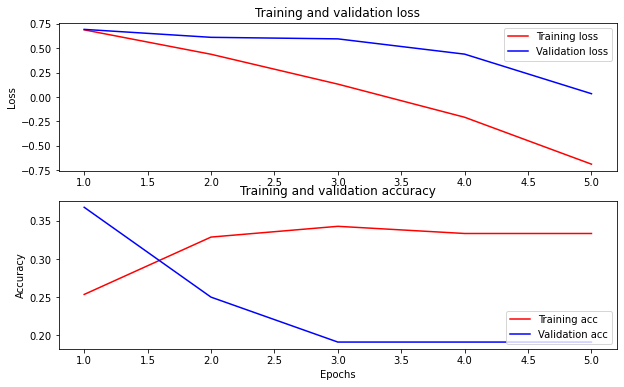

In [34]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [36]:
dataset_name = 'labse'
saved_model_path = './models/{}_1'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

In [37]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [39]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.630051
input: The movie was great!           : score: 0.833469
input: The movie was meh.             : score: 0.917193
input: The movie was okish.           : score: 0.908582
input: The movie was terrible...      : score: 0.878267

Results from the model in memory:
input: this is such an amazing movie! : score: 0.630051
input: The movie was great!           : score: 0.833469
input: The movie was meh.             : score: 0.917193
input: The movie was okish.           : score: 0.908583
input: The movie was terrible...      : score: 0.878267

